<a href="https://colab.research.google.com/github/Quasar-15/Multi-Objective-Online-Convex-Optimization/blob/main/Codes/Pytorch_Alt_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

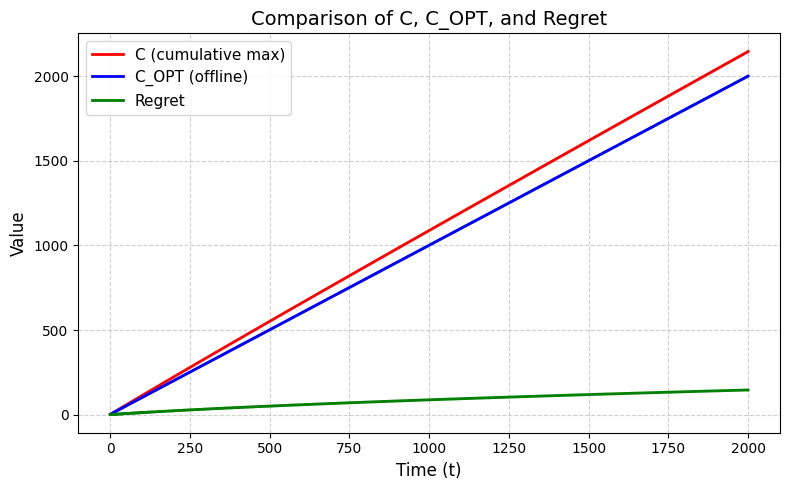


Sampled values of x and xstar:

   t   x[t]  xstar[t]
   0 0.9000       1.0
 105 0.7352       0.0
 210 0.6616       0.0
 315 0.6135       0.0
 421 0.5725       0.0
 526 0.5376       0.0
 631 0.5126       0.0
 736 0.4880       0.0
 842 0.4680       0.0
 947 0.4516       0.0
1052 0.4347       0.0
1157 0.4215       0.0
1263 0.4083       0.0
1368 0.3955       0.0
1473 0.3852       0.0
1578 0.3741       0.0
1684 0.3644       0.0
1789 0.3560       0.0
1894 0.3468       0.0
2000 0.3387       0.0
   t  theta[t]
   0    0.5000
 105    0.2726
 210    0.1283
 315    0.0559
 421    0.0237
 526    0.0102
 631    0.0044
 736    0.0019
 842    0.0008
 947    0.0004
1052    0.0002
1157    0.0001
1263    0.0000
1368    0.0000
1473    0.0000
1578    0.0000
1684    0.0000
1789    0.0000
1894    0.0000
2000    0.0000


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch  # Import PyTorch

# --- Problem / coefficient setup (your values) ---
a1, b1 = 1.0, 1.0
a2, b2 = -1.2, 1.4
c1, d1 = -1.0, 2.0
c2, d2 = 1.3, 0.0

# initial quantities
N = 1000
T = 2 * N
num_points = 20
eta2 = math.sqrt(math.log(2) / T)
#eta = 1.0 / math.sqrt(T)
x0 = 0.9
w1_0, w2_0 = 1.0, 1.0

# coefficient arrays (length T+1)
a = np.zeros(T + 1, dtype=float)
b = np.zeros(T + 1, dtype=float)
c = np.zeros(T + 1, dtype=float)
d = np.zeros(T + 1, dtype=float)

for t in range(0, T + 1):
    if t % 2 == 0:
        a[t], b[t], c[t], d[t] = a1, b1, c1, d1
    else:
        a[t], b[t], c[t], d[t] = a2, b2, c2, d2

# --- variables for algorithm ---
w1 = np.zeros(T + 1, dtype=float)
w2 = np.zeros(T + 1, dtype=float)
theta = np.zeros(T + 1, dtype=float)
x = np.zeros(T + 1, dtype=float)

w1[0], w2[0] = w1_0, w2_0
theta[0] = w1[0] / (w1[0] + w2[0])
x[0] = x0

# losses per step
ff = np.zeros(T + 1, dtype=float)
gg = np.zeros(T + 1, dtype=float)
ff[0] = a[0] * x[0] + b[0]
gg[0] = c[0] * x[0] + d[0]

# --- PyTorch setup for OGD ---
# We initialize the parameter to optimize.
# requires_grad=True tells PyTorch to track operations for auto-differentiation.
x_param = torch.tensor([x0], dtype=torch.float32, requires_grad=True)

# We use SGD. The learning rate will be updated dynamically in the loop.
optimizer = torch.optim.SGD([x_param], lr=1.0)

# --- OGD + Hedge loop ---
for t in range(0, T):
    # Hedge update using losses at time t (note ff[t], gg[t] are already computed)
    w1[t + 1] = w1[t] * math.exp(eta2 * ff[t])
    w2[t + 1] = w2[t] * math.exp(eta2 * gg[t])
    theta[t + 1] = w1[t + 1] / (w1[t + 1] + w2[t + 1])

    # --- PyTorch OGD Step ---

    # 1. Update learning rate for this step (eta = 1/(t+1))
    eta = 1.0 / (t + 1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = eta

    # 2. Zero gradients from previous step
    optimizer.zero_grad()

    # 3. Define the surrogate loss: L_t(x) = theta * f_t(x) + (1-theta) * g_t(x)
    # We convert numpy scalars to torch tensors for the calculation
    loss_f = torch.tensor(a[t], dtype=torch.float32) * x_param + torch.tensor(b[t], dtype=torch.float32)
    loss_g = torch.tensor(c[t], dtype=torch.float32) * x_param + torch.tensor(d[t], dtype=torch.float32)

    # The weighted combination (surrogate loss)
    surrogate_loss = torch.tensor(theta[t], dtype=torch.float32) * loss_f + \
                     torch.tensor(1.0 - theta[t], dtype=torch.float32) * loss_g

    # 4. Backward pass (compute gradients automatically)
    surrogate_loss.backward()

    # 5. Optimizer step (x = x - eta * grad)
    optimizer.step()

    # 6. Projection step (equivalent to np.clip)
    # We manipulate the data directly to enforce constraints [0, 1]
    with torch.no_grad():
        x_param.clamp_(0.0, 1.0)

    # Store result back in numpy array
    x[t + 1] = x_param.item()

    # --- End PyTorch OGD Step ---

    # evaluate losses at t+1 (using the new x[t+1])
    ff[t + 1] = a[t + 1] * x[t + 1] + b[t + 1]
    gg[t + 1] = c[t + 1] * x[t + 1] + d[t + 1]

# --- cumulative sums of played-out losses ---
Sf = np.cumsum(ff)   # Sf[t] = sum_{s=0..t} ff[s]
Sg = np.cumsum(gg)
cumC = np.maximum(Sf, Sg)   # this is your 'C' over time (cumulative max cost)

# --- build cumulative A,B,C,D (prefix sums of a,b,c,d) ---
A = np.cumsum(a)   # A[t] = sum_{s=0..t} a[s]
B = np.cumsum(b)
Ac = np.cumsum(c)  # renamed to avoid colliding with cumC or C_OPT
D = np.cumsum(d)

# --- compute xstar(t) = argmin_{x in [0,1]} max(A[t] * x + B[t], Ac[t] * x + D[t]) ---
def compute_xstar(A, B, Ac, D):
    Tloc = len(A) - 1
    xstar = np.zeros(Tloc + 1, dtype=float)

    for t in range(Tloc + 1):
        if A[t] == Ac[t]:
            # same slope: pick 0 or 1 depending which gives smaller max
            val0 = max(A[t] * 0 + B[t], Ac[t] * 0 + D[t])
            val1 = max(A[t] * 1 + B[t], Ac[t] * 1 + D[t])
            xstar[t] = 0.0 if val0 <= val1 else 1.0
        else:
            xc = (D[t] - B[t]) / (A[t] - Ac[t])
            xc = np.clip(xc, 0.0, 1.0)
            candidates = np.array([0.0, 1.0, xc])
            vals = np.maximum(A[t] * candidates + B[t], Ac[t] * candidates + D[t])
            # tie-breaker: choose first occurrence (0), or you can prefer xc by checking equality
            xstar[t] = candidates[np.argmin(vals)]

    return xstar

xstar = compute_xstar(A, B, Ac, D)

# --- Compute C_OPT(t) and Regret(t) ---
C_OPT = np.zeros(T + 1, dtype=float)
Regret = np.zeros(T + 1, dtype=float)

# Vectorized computation
sum_f_all = xstar * A + B      # sum_{s=0..t} f(s, xstar[t])
sum_g_all = xstar * Ac + D     # sum_{s=0..t} g(s, xstar[t])
C_OPT = np.maximum(sum_f_all, sum_g_all)

# Regret = actual cumulative max cost - offline optimal for that t
Regret = cumC - C_OPT

# --- Plot (example) ---
T_steps = np.arange(T + 1)

plt.figure(figsize=(8, 5))
plt.plot(T_steps, cumC, label='C (cumulative max)', color='red', linewidth=2)
plt.plot(T_steps, C_OPT, label='C_OPT (offline)', color='blue', linewidth=2)
plt.plot(T_steps, Regret, label='Regret', color='green', linewidth=2)
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Comparison of C, C_OPT, and Regret', fontsize=14)
plt.legend(loc='best', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Get equally spaced indices
indices = np.linspace(0, T, num_points, dtype=int)

# Create a DataFrame for clean display
df1 = pd.DataFrame({
    't': indices,
    'x[t]': x[indices],
    'xstar[t]': xstar[indices]
})

df2 = pd.DataFrame({
    't': indices,
    'theta[t]': theta[indices]
})
# Round values for neatness
df1 = df1.round(4)
df2 = df2.round(4)
print("\nSampled values of x and xstar:\n")
print(df1.to_string(index=False))
print(df2.to_string(index=False))